In [1]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [4]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, predicted_feature]) # 2 stands for prediction of Z!!! (3rd col)
    return np.array(dataX), np.array(dataY)

In [32]:
# Function

def train_vector(df, predicted_feature):
    
    # load the dataset
    dataset = df.values
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.8) 
    test_size = len(dataset) - train_size
    train=dataset[0 : train_size]
    test=dataset[train_size - 60 : ]
    
    #Scale the data
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    # reshape into X=t and Y=t+1
    look_back = 60 # this is the window
    trainX, trainY = create_dataset(train, look_back)  
    testX, testY = create_dataset(test, look_back)
    # reshape input to be  [length of train/test data, window size (def=60), features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
    testX = np.reshape(testX, (testX.shape[0],look_back, 6))
    
    # Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    history=model.fit(trainX, trainY, batch_size=256, epochs=50)

    predictions = model.predict(testX)
    predict_ext = np.zeros((len(predictions), 6))
    predict_ext[:,predicted_feature] = predictions[:,0]
    predictions = scaler.inverse_transform(predict_ext)[:,predicted_feature]
    
    testY_extended = np.zeros((len(testY),6))
    testY_extended[:,predicted_feature]=testY
    testY=scaler.inverse_transform(testY_extended)[:,predicted_feature]
    
    rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
    print(f'RMSE for feature {predicted_feature} is: ' + str(rmse))
    
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    df_pred[str(predicted_feature)]=pred_s
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

In [33]:
# Call for full 6D training

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['0', '1', '2', '3', '4', '5'])

for feature in range(0,6):
    train_vector(df, feature)
    
df_pred

Epoch 1/50
3/3 [==============================] - 1s 196ms/step - loss: 0.1718
Epoch 2/50
3/3 [==============================] - 1s 198ms/step - loss: 0.1023
Epoch 3/50
3/3 [==============================] - 1s 206ms/step - loss: 0.0943
Epoch 4/50
3/3 [==============================] - 1s 188ms/step - loss: 0.0500
Epoch 5/50
3/3 [==============================] - 1s 187ms/step - loss: 0.0391
Epoch 6/50
3/3 [==============================] - 1s 189ms/step - loss: 0.0128
Epoch 7/50
3/3 [==============================] - 1s 198ms/step - loss: 0.0090
Epoch 8/50
3/3 [==============================] - 1s 187ms/step - loss: 0.0059
Epoch 9/50
3/3 [==============================] - 1s 204ms/step - loss: 0.0106
Epoch 10/50
3/3 [==============================] - 1s 181ms/step - loss: 0.0061
Epoch 11/50
3/3 [==============================] - 1s 186ms/step - loss: 0.0037
Epoch 12/50
3/3 [==============================] - 1s 189ms/step - loss: 0.0023
Epoch 13/50
3/3 [==============================] 

3/3 [==============================] - 1s 214ms/step - loss: 4.2818e-04
RMSE for feature 1 is: 1961.4155338825217
Epoch 1/50
3/3 [==============================] - 1s 271ms/step - loss: 0.2936
Epoch 2/50
3/3 [==============================] - 1s 470ms/step - loss: 0.1657
Epoch 3/50
3/3 [==============================] - 2s 766ms/step - loss: 0.1001
Epoch 4/50
3/3 [==============================] - 2s 743ms/step - loss: 0.1069
Epoch 5/50
3/3 [==============================] - 1s 215ms/step - loss: 0.0754
Epoch 6/50
3/3 [==============================] - 1s 216ms/step - loss: 0.0562
Epoch 7/50
3/3 [==============================] - 1s 215ms/step - loss: 0.0480
Epoch 8/50
3/3 [==============================] - 1s 228ms/step - loss: 0.0271
Epoch 9/50
3/3 [==============================] - 1s 235ms/step - loss: 0.0174
Epoch 10/50
3/3 [==============================] - 1s 212ms/step - loss: 0.0078
Epoch 11/50
3/3 [==============================] - 1s 204ms/step - loss: 0.0038
Epoch 12/50
3/3

3/3 [==============================] - 1s 202ms/step - loss: 5.7739e-04
RMSE for feature 3 is: 0.1779287348591461
Epoch 1/50
3/3 [==============================] - 1s 226ms/step - loss: 0.2206
Epoch 2/50
3/3 [==============================] - 1s 226ms/step - loss: 0.1333
Epoch 3/50
3/3 [==============================] - 1s 226ms/step - loss: 0.1026
Epoch 4/50
3/3 [==============================] - 1s 217ms/step - loss: 0.0594
Epoch 5/50
3/3 [==============================] - 1s 250ms/step - loss: 0.0425
Epoch 6/50
3/3 [==============================] - 1s 218ms/step - loss: 0.0153
Epoch 7/50
3/3 [==============================] - 1s 215ms/step - loss: 0.0102
Epoch 8/50
3/3 [==============================] - 1s 253ms/step - loss: 0.0064
Epoch 9/50
3/3 [==============================] - 1s 315ms/step - loss: 0.0106
Epoch 10/50
3/3 [==============================] - 1s 283ms/step - loss: 0.0084
Epoch 11/50
3/3 [==============================] - 1s 274ms/step - loss: 0.0033
Epoch 12/50
3/3

3/3 [==============================] - 1s 213ms/step - loss: 4.5963e-04
Epoch 50/50
3/3 [==============================] - 1s 211ms/step - loss: 4.4529e-04
RMSE for feature 5 is: 0.08156478576434804


,0,1,2,3,4,5
0,-38455.915565,-40183.781515,-20172.278358,-2.837378,-2.801844,-1.405306
1,-36736.245469,-38373.478071,-19055.438355,-2.697875,-2.674078,-1.329664
2,-30054.662693,-31474.914559,-15326.269694,-2.198679,-2.179978,-1.070059
3,-19289.935343,-20339.062862,-9456.539424,-1.402365,-1.382476,-0.659195
4,-5838.445496,-6380.889317,-2188.823496,-0.407965,-0.382586,-0.148932
...,...,...,...,...,...,...
195,35945.537779,35867.059469,18861.076132,2.530050,2.739433,1.361555
196,28385.179241,27698.185100,14415.002331,1.933425,2.163188,1.062764
197,17169.230091,15818.925021,8149.526313,1.081014,1.308506,0.630602
198,3762.972142,1833.445734,896.971536,0.086944,0.291195,0.120483


In [37]:
#Rename predictions df columns from numerals
df_pred.columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv']
df_pred

,x,y,z,x_vv,y_vv,z_vv
0,-38455.915565,-40183.781515,-20172.278358,-2.837378,-2.801844,-1.405306
1,-36736.245469,-38373.478071,-19055.438355,-2.697875,-2.674078,-1.329664
2,-30054.662693,-31474.914559,-15326.269694,-2.198679,-2.179978,-1.070059
3,-19289.935343,-20339.062862,-9456.539424,-1.402365,-1.382476,-0.659195
4,-5838.445496,-6380.889317,-2188.823496,-0.407965,-0.382586,-0.148932
...,...,...,...,...,...,...
195,35945.537779,35867.059469,18861.076132,2.530050,2.739433,1.361555
196,28385.179241,27698.185100,14415.002331,1.933425,2.163188,1.062764
197,17169.230091,15818.925021,8149.526313,1.081014,1.308506,0.630602
198,3762.972142,1833.445734,896.971536,0.086944,0.291195,0.120483


### Compare and plot results/errors SEPARATELY

In [49]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]


train_df = df[:train_size]

test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [52]:
df_pred.index=test_df.index

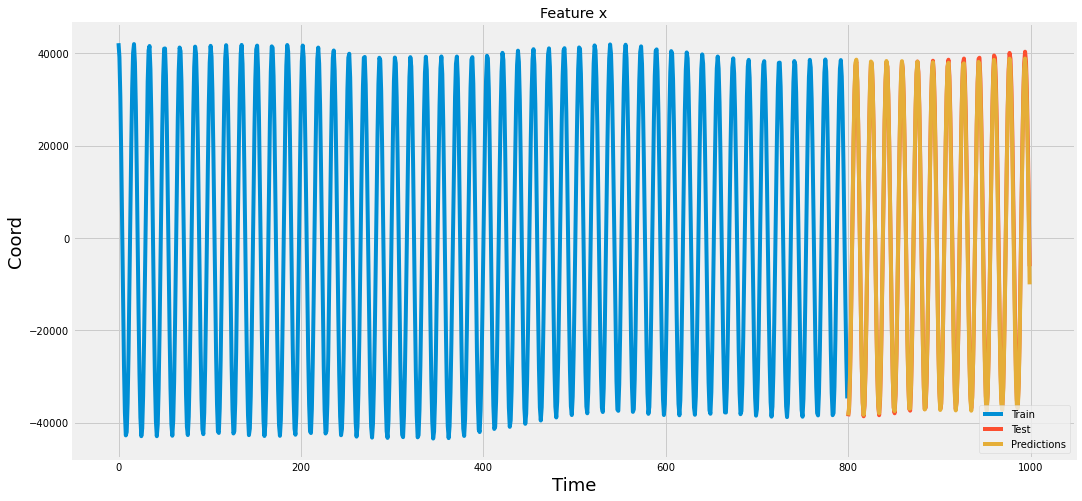

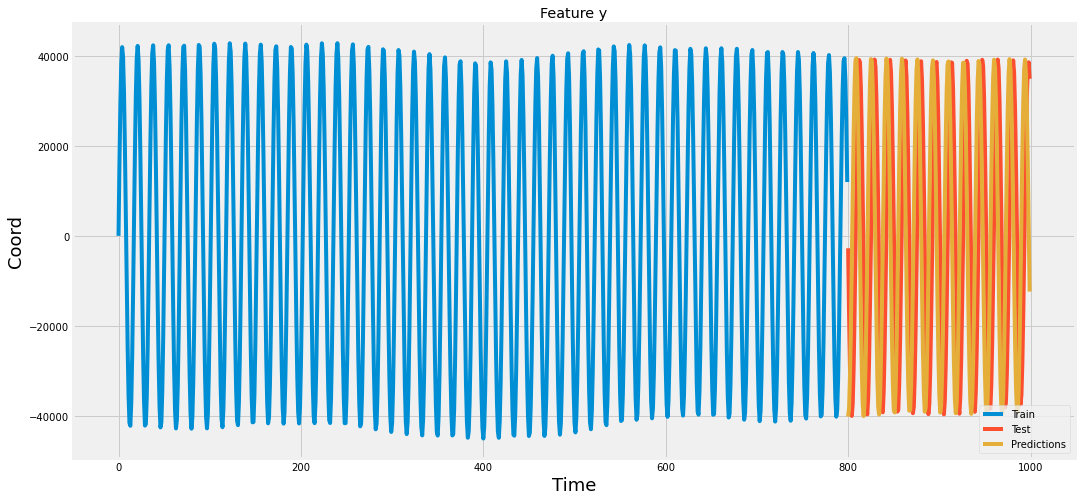

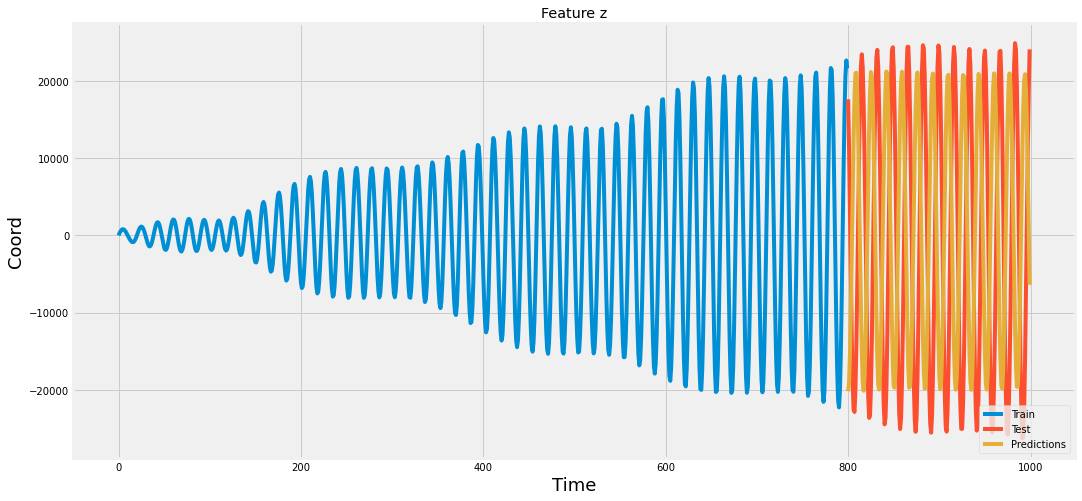

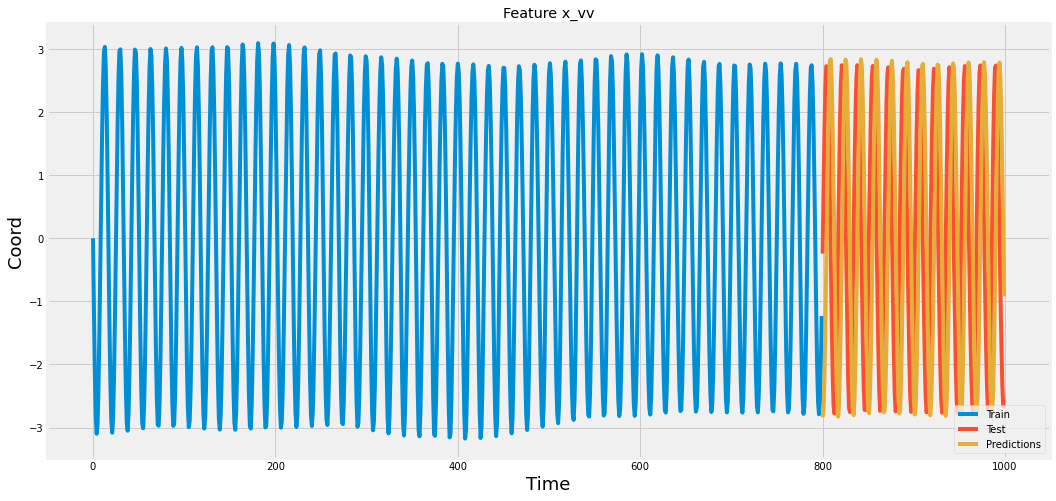

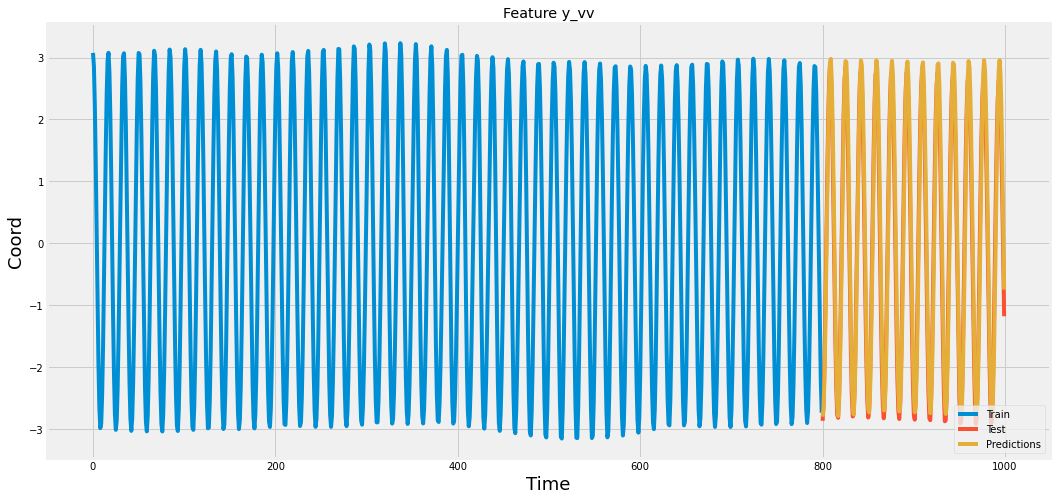

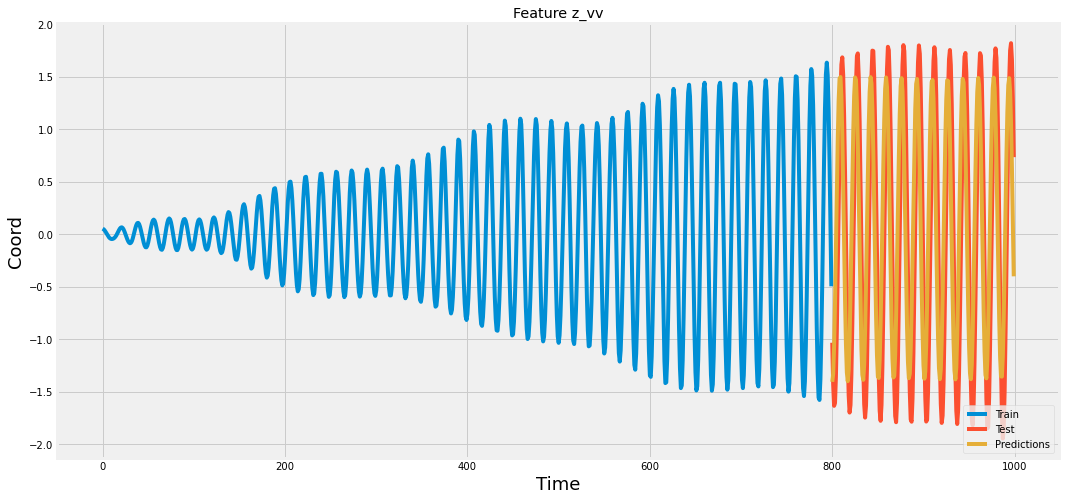

In [53]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature])
    plt.plot(test_df[feature])
    plt.plot(df_pred[feature])

    plt.title(f'Feature {feature}')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Coord', fontsize=18)
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()


In [ ]:
dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as ISS semi-major axis
dff.Error.plot()